In [44]:
import sys
sys.path.append('../')
import pystan
import stan_utility

import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd

In [78]:
import matplotlib.pyplot as plt
import matplotlib as mpl

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"
blue="#0000FF"
dark_blue="#00008B"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [79]:
#Data loading
dts=[24,734,25,516,31,754,31,877,22,814,21,362,26,764,20,809,16,223,22,1066]
c1=dts[::2]
c2=dts[1::2]

Airline_data=pd.DataFrame({'Year':[1976,1977,1978,1979,1980,1981,1982,1983,1984,1985],
'Fatal accidents':c1,  
'Passenger deaths':c2,
'Death rate':[0.19,0.12,0.15,0.16,0.14,0.06,0.13,0.13,0.03,0.15]}).set_index('Year')
Airline_data['Miles flown [100 mln miles]']=np.round(Airline_data['Passenger deaths']/Airline_data['Death rate'])

## generation of vector for plotting samples under histograms
acc=[]
dta_cnt=[]
for k in Airline_data['Fatal accidents']:  
    dta_cnt.append(-(1.+acc.count(k)))
    acc.append(k)
dta_cnt=np.array(dta_cnt)

Airline_data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [80]:
#Execrise 1
"""""
First we need to create simple prior model. We will try to predict annual number of passenger deaths with poisson distribution.
We assume that the annual chance of 20 000 deaths is very small, therefore we want our distribution with a probability less than 1% to accept 20 000 deaths.
"""""
root_of_lam=np.polynomial.polynomial.polyroots([-20000.,3.,1.])
lambda_1=np.round(root_of_lam[root_of_lam>0]**2)
print(lambda_1)
"""""
Below we can see stan model of half-normal distribution (-0,5). That model give us 99% of probability that less than 2 people are dying because of aircraft disaster everyday. Our prior need to have probability of lambda equal to 99%.
"""""

[19580.]


'""\nBelow we can see stan model of half-normal distribution (-0,5). That model give us 99% of probability that less than 2 people are dying because of aircraft disaster everyday. Our prior need to have probability of lambda equal to 99%.\n'

In [81]:
with open('Exercise1.stan', 'r') as file:
    print(file.read())

functions {
  vector tail_delta(vector y, vector theta, real[] x_r, int[] x_i) {
    vector[1] deltas;
    deltas[1] = 2 * (normal_cdf(theta[1], 0, exp(y[1])) - 0.5) - 0.99;
    return deltas;
  }
}

data {
  vector[1] y_guess;
  vector[1] theta;
}

transformed data {

  vector[1] y;
  real x_r[0];
  int x_i[0];

  y = algebra_solver(tail_delta, y_guess, theta, x_r, x_i);
}

generated quantities {
  real sigma = exp(y[1]);
}



In [82]:
model=stan_utility.compile_model('Exercise1.stan')


Using cached StanModel


In [83]:
sim_data={'y_guess': np.array([np.log(10000)]), 'theta': np.array(lambda_1)}
sim_ppc=model.sampling(data=sim_data,algorithm="Fixed_param", iter=1000, warmup=0, chains=1, refresh=1000,seed=30042020)

7601.435379674908


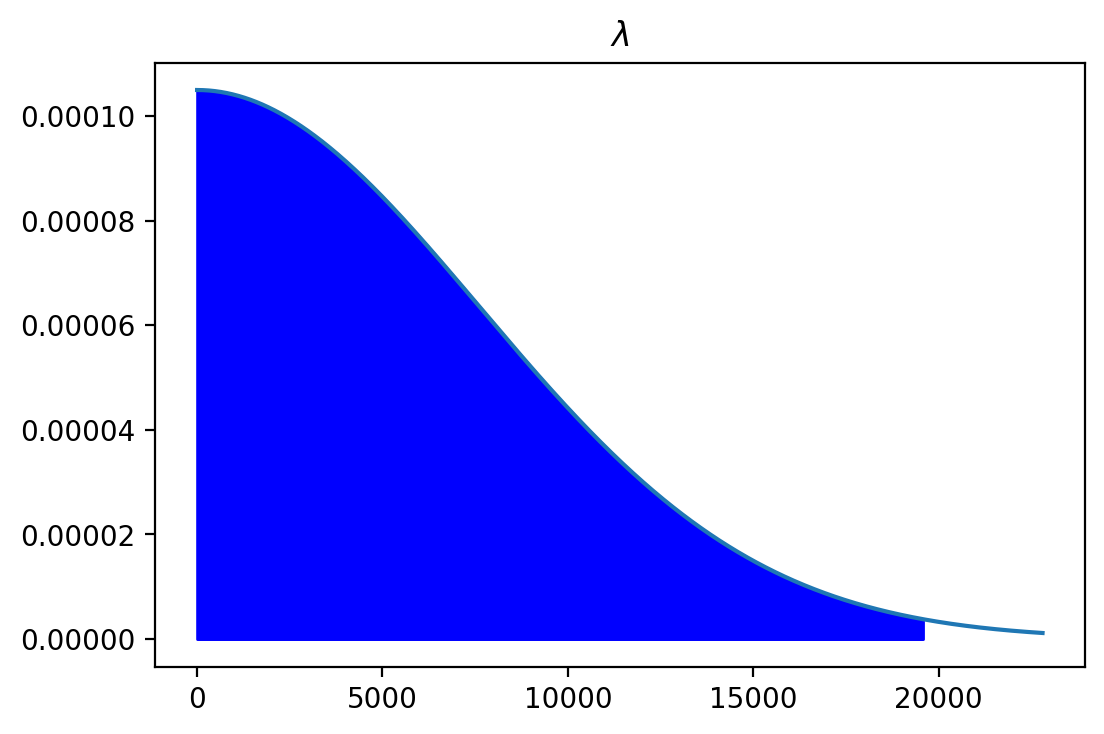

In [84]:
sigma=sim_ppc.extract()['sigma'][0]
print(sigma)
fig, axes = plt.subplots(1, 1)
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,lambda_1[0],1000)
axes.plot(x2,2*stats.norm.pdf(x2,scale=sigma))
axes.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=blue)
axes.set_title(r'$\lambda$')
plt.show()

In [85]:
#Prior predictive check
"""""
Based on the calculated parameters, we can try the appropriate half-normal distribution and poisson distribution.
"""""


'""\nBased on the calculated parameters, we can try the appropriate half-normal distribution and poisson distribution.\n'

In [86]:
with open('Exercise1B.stan', 'r') as file:
    print(file.read())

data {
  int M;
}

generated quantities {
  real lambda=fabs(normal_rng(0,7601));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(lambda);
  }
}



In [87]:
model_prior_predictive =stan_utility.compile_model('Exercise1B.stan')


Using cached StanModel


In [88]:
sim_data={'M': 1}
sim_prior_predictive=model_prior_predictive.sampling(data=sim_data,algorithm="Fixed_param", iter=1000, warmup=0, chains=1, refresh=1000,seed=29042020)

In [89]:
dta_cnt

array([-1., -1., -1., -2., -1., -1., -1., -1., -1., -2.])

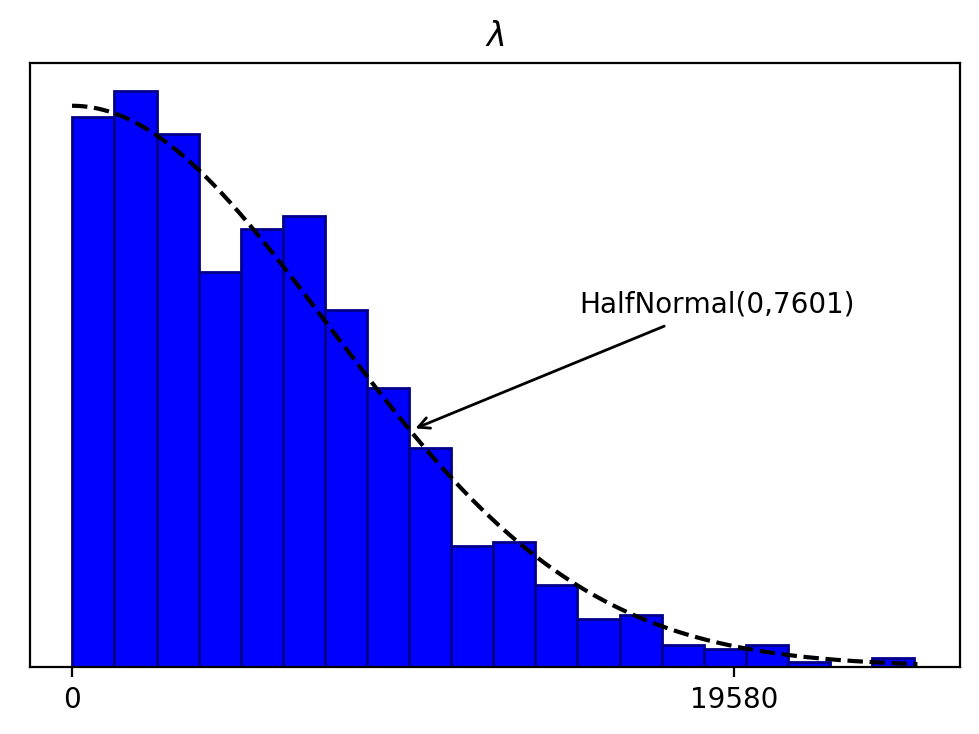

In [96]:
params=sim_prior_predictive.extract()
lambda1=params['lambda']
y_sim=params['y_sim']

fig, axes = plt.subplots(1, 1)
axes.hist(lambda1,bins=20,color=blue,edgecolor=dark_blue,density=True)
x=np.linspace(0,25000,2000)
axes.set_xticks([0,lambda_1[0]])
axes.set_yticks([])
axes.set_title(r'$\lambda$')
axes.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(10000,0,sigma)
axes.annotate('HalfNormal(0,'+str(np.int(sigma))+')',xy=(10000,arr_y_loc),xytext=(15000,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
plt.show()

In [97]:
#Posterior distribution
"""""
Now we can try to create model to predict number of deaths in 1986

"""""
with open('Exercise1C.stan', 'r') as file:
    print(file.read())


data {
    int M;
    int y[M];
}
parameters {
    real<lower=0>lambda;
}
model {
    lambda ~ normal(0, 253);
    for (k in 1:M) {
        y[k] ~ poisson(lambda);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(lambda);
    }
}



In [99]:
model_posterior =stan_utility.compile_model('Exercise1C.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f98a21cb2843073a0cc11ab7a5dbb1d NOW.


In [106]:
sim_data={'M': len(Airline_data), 'y': Airline_data['Passenger deaths']}
sim_posterior=model_posterior.sampling(data=sim_data,seed=8052020)

In [120]:
params=sim_posterior.extract()
lam=params['lambda']
y_sim=params['y_sim']
mean_lam = np.mean(lam)
cinf_lam = az.hpd(lam,0.99)

hpd_width=cinf_lam[1]-cinf_lam[0]

print('Mean lambda : {:4.5f}'.format(mean_lam))
print('99% confidence interval: [',*['{:4.5f}'.format(k) for k in cinf_lam],']')

Mean lambda : 691.41300
99% confidence interval: [ 670.31452 712.05422 ]


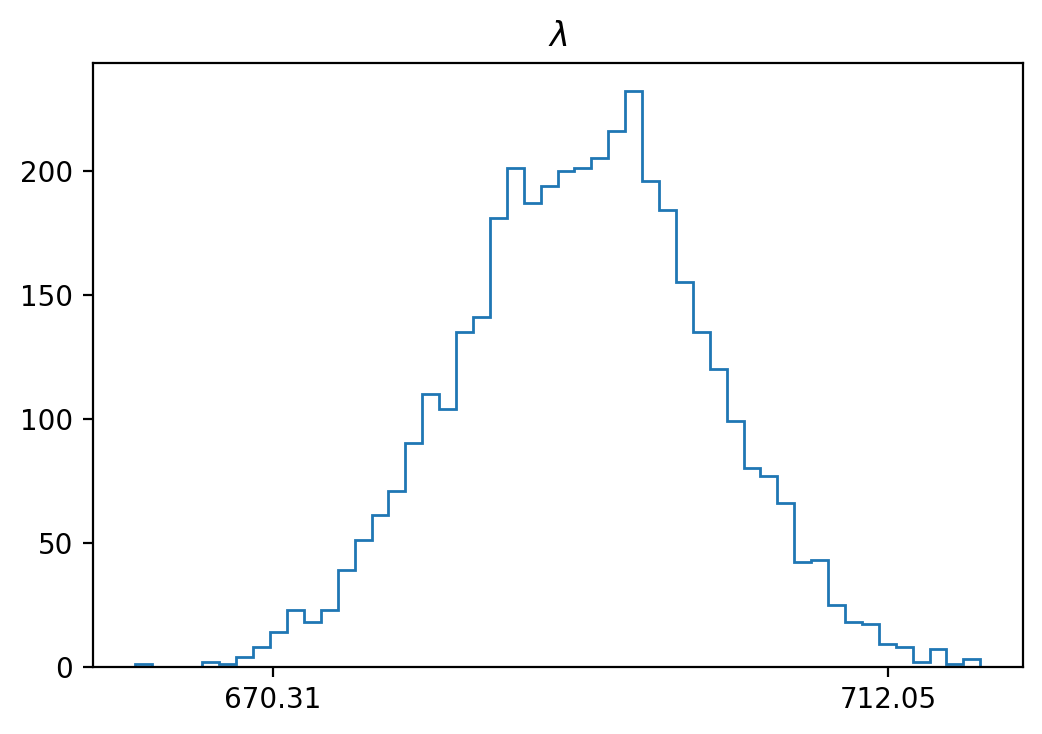

In [123]:
"""""
Poisson distribution - interval bounds are marked
"""""
fig, axes = plt.subplots(1, 1)
axes.set_title(r'$\lambda$')
axes.hist(lam, histtype = 'step', bins = 50)
axes.set_xticks([cinf_lam[0], cinf_lam[1]])
plt.show()

In [124]:
"""""
Prediction of death rate from the model.
"""""
median_y_sim = np.median(y_sim.flatten())
cinf_y_sim = az.hpd(y_sim.flatten(),0.89)

print('Median of predicted accidents =',median_y_sim)
print('Confidence interval = [',*cinf_y_sim,']')

Median of predicted accidents = 691.0
Confidence interval = [ 647.0 734.0 ]


In [125]:
#Execrise 2
"""""
Now we might predict passengers deaths in 1986 (out of Data). As stated before in 1986, there were 22 fatal accidents, 546 passenger deaths, and a death rate of 0.06 per 100 million miles flown.
The intensity is constant, but rate is a product of intensity and miles flown.
"""""
mean_miles=np.mean(Airline_data['Miles flown [100 mln miles]'])
root_of_theta=np.polynomial.polynomial.polyroots([-20000/mean_miles,3./np.sqrt(mean_miles),1.])
theta_ub=(root_of_theta[root_of_lam>0]**2)
print('theta upper bound','{:4.3f}'.format(theta_ub[0]))


theta upper bound 3.426


In [128]:
sim_data=dict(y_guess=np.array([np.log(1)]),theta=np.array(theta_ub))
tuned2 = model.sampling(data=sim_data,
                          seed=1052020,
                          algorithm="Fixed_param",
                          iter=1, 
                          warmup=0,
                          chains=1)
sigma = (tuned2.extract()['sigma'][0])
print('sigma =','{:4.3f}'.format(sigma))
print('theta_ub =',theta_ub)

sigma = 1.330
theta_ub = [3.42562932]


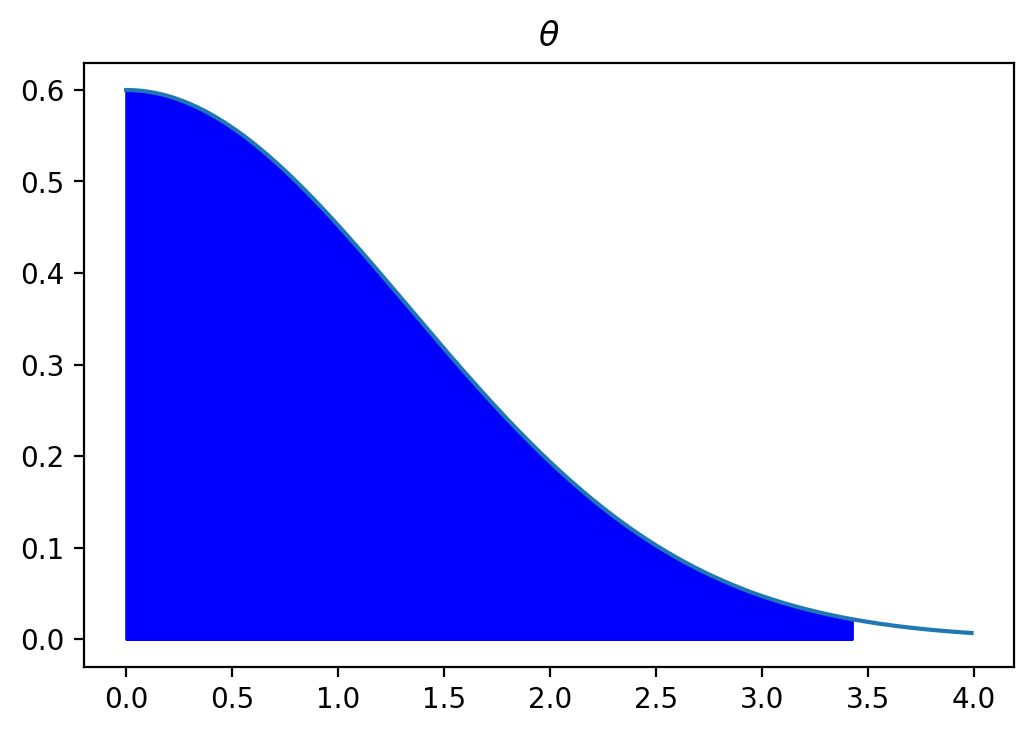

In [130]:
fig, axes = plt.subplots(1, 1)
x2=np.linspace(0,3*sigma,1000)
x4=np.linspace(0,theta_ub[0],1000)
axes.plot(x2,2*stats.norm.pdf(x2,scale=sigma))
axes.fill_between(x4,2*stats.norm.pdf(x4,scale=sigma),0,color=blue)
axes.set_title(r'$\theta$')
plt.show()

In [131]:
#Prior predictive check
"""""
Based on the calculated parameters, we can try the appropriate half-normal distribution and poisson distribution.
"""""
with open('Exercise2.stan', 'r') as file:
    print(file.read())

data {
  int M;
  vector[M] miles;
}


generated quantities {
  real theta=fabs(normal_rng(0,1.33));
  int y_sim[M];
  for (k in 1:M) {
    y_sim[k] = poisson_rng(theta*miles[k]);
  }
}



In [132]:
model_prior=stan_utility.compile_model('Exercise2.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cca38e1d8c80c2aea89bcedc8f556868 NOW.


In [135]:
data_prior=dict(M=len(Airline_data),miles=Airline_data['Miles flown [100 mln miles]'].to_numpy())
sim_uf=model_prior.sampling(data=data_prior,algorithm="Fixed_param", iter=1000, warmup=0, chains=1, refresh=1000,seed=29042020)

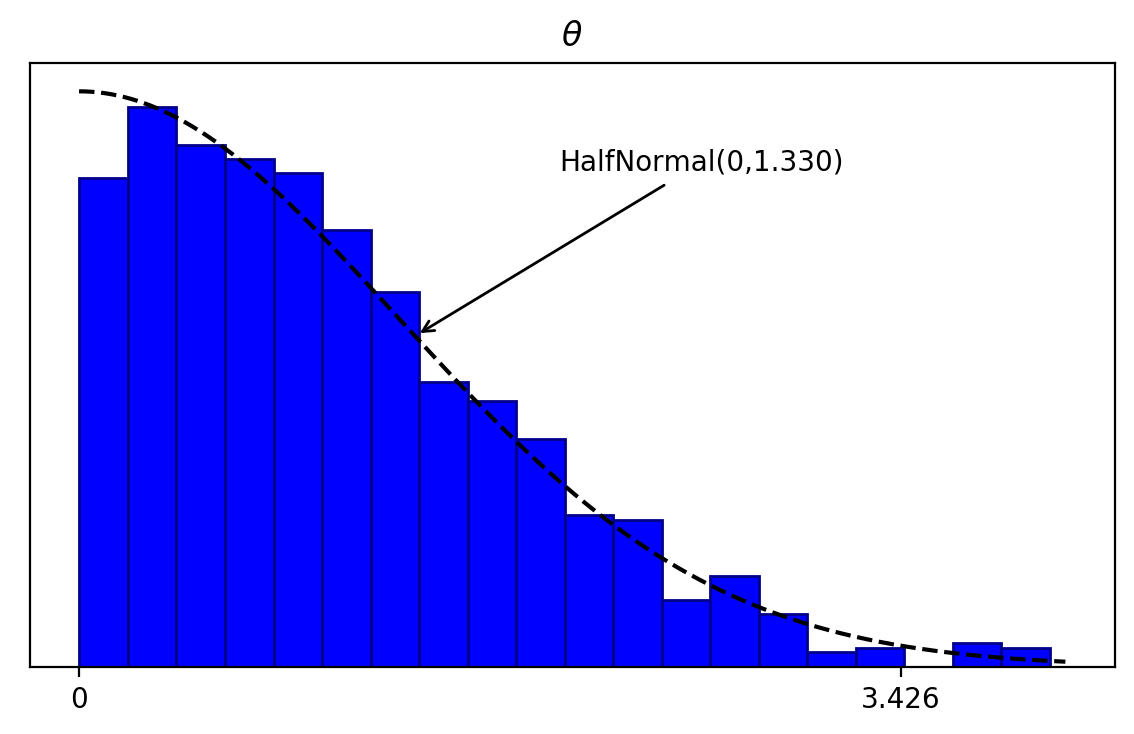

In [139]:
params=sim_uf.extract()
theta=params['theta']

fig, axes = plt.subplots(1, 1,figsize=(7, 4))
axes.hist(theta,bins=20,color=blue,edgecolor=dark_blue,density=True)
x=np.linspace(0,1.2*theta_ub[0],2000)
axes.set_xticks([0,theta_ub[0]])
axes.set_xticklabels([0,np.round(theta_ub[0],3)])
axes.set_yticks([])
axes.plot(x,2*stats.norm.pdf(x,0,sigma),color='black',linestyle='--')
arr_y_loc = 2*stats.norm.pdf(1.4,0,sigma)
axes.annotate('HalfNormal(0,'+'{:4.3f}'.format(sigma)+')',xy=(1.4,arr_y_loc),xytext=(2,1.5*arr_y_loc),arrowprops={'arrowstyle':'->'})
axes.set_title(r'$\theta$')
plt.show()

In [140]:
"""""
Now we are able to prepare posterior interference.
"""""
with open('Exercise2B.stan', 'r') as file:
    print(file.read())

data {
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, 0.044);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y_sim[M];
    for (k in 1:M) {
        y_sim[k] = poisson_rng(miles[k]*theta);
    }
}



In [141]:
model=stan_utility.compile_model('Exercise2B.stan')


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_33595db2561ae08359fad8d402e805b9 NOW.


In [143]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit = model.sampling(data=data, seed=8052020)

params_miles=fit.extract()
theta=params_miles['theta']
y_sim=params_miles['y_sim']

In [144]:
mean_theta = np.mean(theta)
cinf_theta = az.hpd(theta,0.89)
hpd_width=cinf_theta[1]-cinf_theta[0]
print('Mean theta : {:5.4f}'.format(mean_theta))
print('89% confidence interval: [',*['{:5.4f}'.format(k) for k in cinf_theta],']')

Mean theta : 0.1210
89% confidence interval: [ 0.1187 0.1231 ]


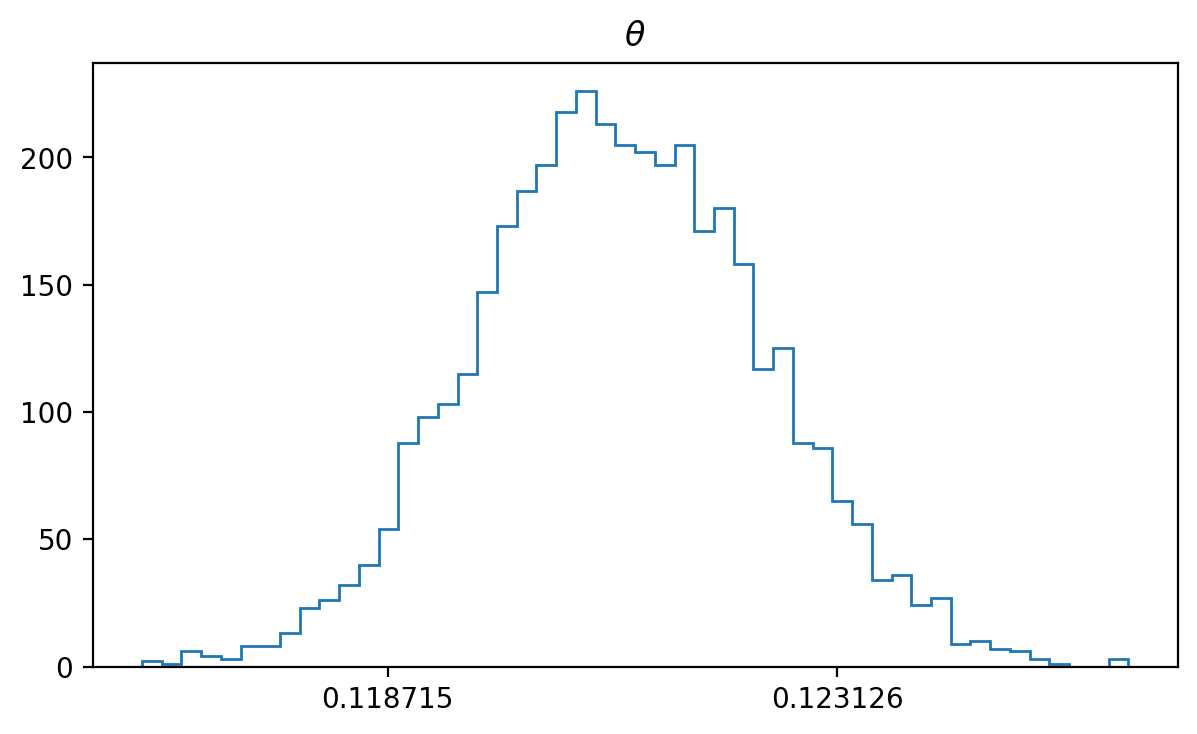

In [150]:
fig, axes = plt.subplots(1, 1,figsize=(7, 4))
axes.set_title(r'$\theta$')
axes.hist(theta, histtype = 'step', bins = 50)
axes.set_xticks([cinf_theta[0], cinf_theta[1]])
plt.show()

In [167]:
with open('Exercise2C.stan', 'r') as file:
    print(file.read())

data {
    int M;
    vector[M] miles;
    int y[M];
}
parameters {
    real<lower=0>theta;
}
model {
    theta ~ normal(0, 0.11);
    for (k in 1:M) {
        y[k] ~ poisson(miles[k]*theta);
    }
}
generated quantities {
    int y1986 = poisson_rng(9100*theta);
}



In [168]:
model1986=stan_utility.compile_model('Exercise2C.stan')

Using cached StanModel


In [169]:
data = dict(M = len(Airline_data),
            miles = Airline_data['Miles flown [100 mln miles]'],
            y = Airline_data['Passenger deaths'])
fit1986 = model1986.sampling(data=data, seed=8052020)

y_1986=fit1986.extract()['y1986']

In [170]:
median_y_1986 = np.median(y_1986)
cinf_y_1986 = az.hpd(y_1986,0.89)

print('Median of predicted accidents =',median_y_1986)
print('Confidence interval = [',*cinf_y_1986,']')

Median of predicted accidents = 1102.0
Confidence interval = [ 1046.0 1157.0 ]


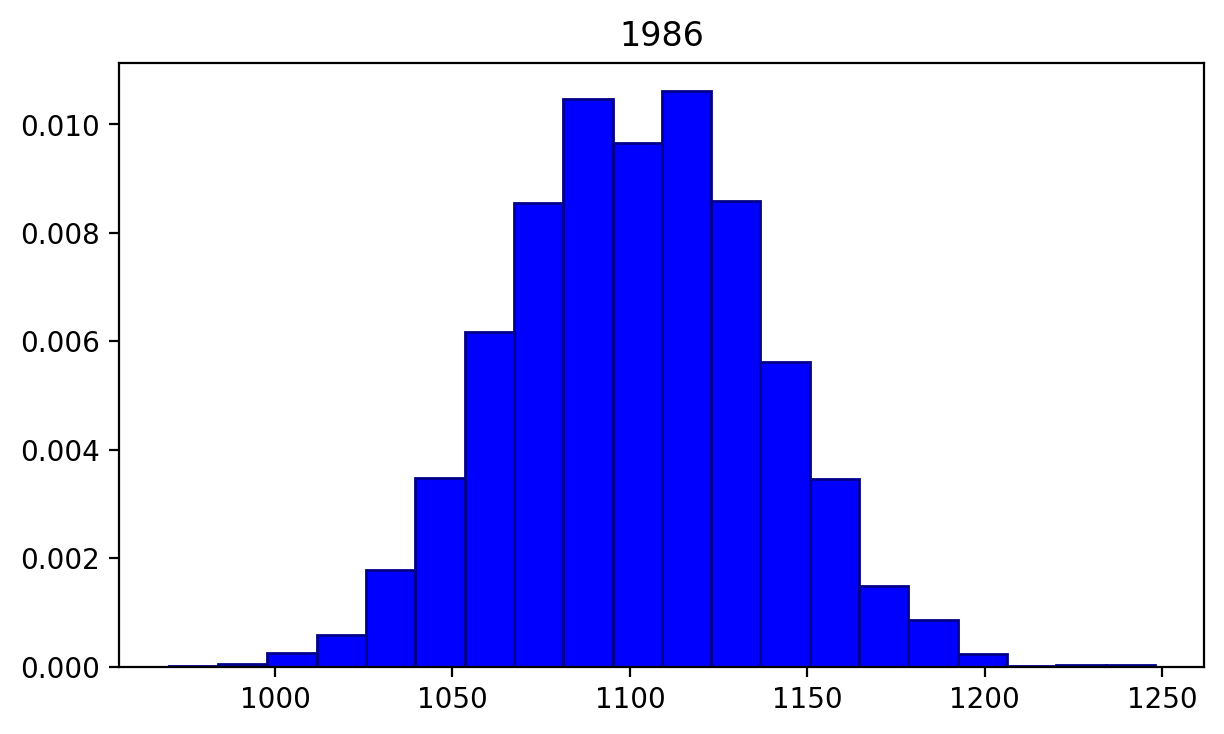

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.hist(y_1986,bins=20,color=blue,edgecolor=dark_blue,density=True)
ax.set_title('1986')
plt.show()
